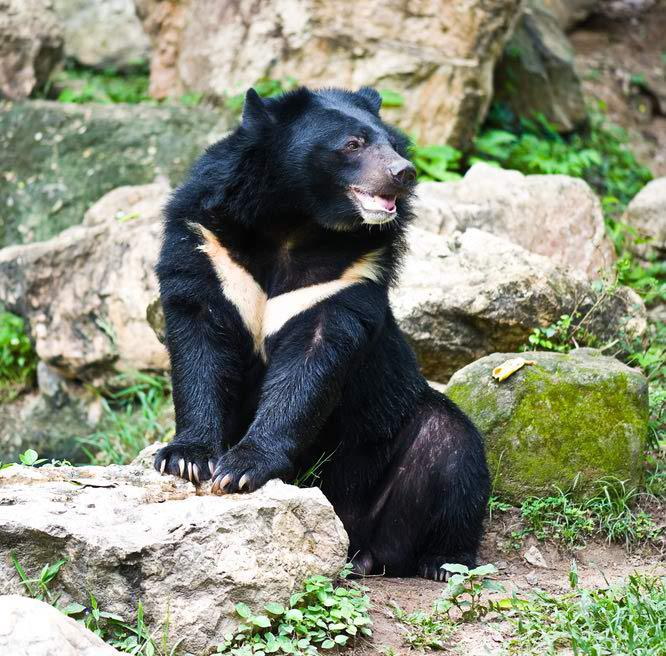

In [87]:
import json
import random
from pathlib import Path

from PIL import Image

sample_img_path = Path("/local/scratch/carlyn.1/datasets/ap-10k/data/000000052100.jpg")
sample_img_annotation_id = 15240
annotation_data_path = Path(
    "/local/scratch/carlyn.1/datasets/ap-10k/annotations/ap10k-train-split1.json"
)

with open(annotation_data_path, "r") as f:
    ann_data = json.load(f)


#annotations = [
#    x for x in ann_data["annotations"] if x["id"] == sample_img_annotation_id
#][0]

random.shuffle(ann_data["annotations"])
annotations = [
    x for x in ann_data["annotations"] if x["category_id"] == 50
][0]

sample_img_path = [
    x for x in ann_data["images"] if x['id'] == annotations['image_id']
][0]

sample_img_path = Path("/local/scratch/carlyn.1/datasets/ap-10k/data/") / sample_img_path["file_name"]

sample_image = Image.open(sample_img_path)

sample_image

In [88]:
keypoint_names = ann_data["categories"][0][
    "keypoints"
]  # names are the same across all animals (categories)
print(keypoint_names)
skeleton_links = ann_data["categories"][0]["skeleton"]
print(skeleton_links)

['left_eye', 'right_eye', 'nose', 'neck', 'root_of_tail', 'left_shoulder', 'left_elbow', 'left_front_paw', 'right_shoulder', 'right_elbow', 'right_front_paw', 'left_hip', 'left_knee', 'left_back_paw', 'right_hip', 'right_knee', 'right_back_paw']
[[1, 2], [1, 3], [2, 3], [3, 4], [4, 5], [4, 6], [6, 7], [7, 8], [4, 9], [9, 10], [10, 11], [5, 12], [12, 13], [13, 14], [5, 15], [15, 16], [16, 17]]


# Color Assignment

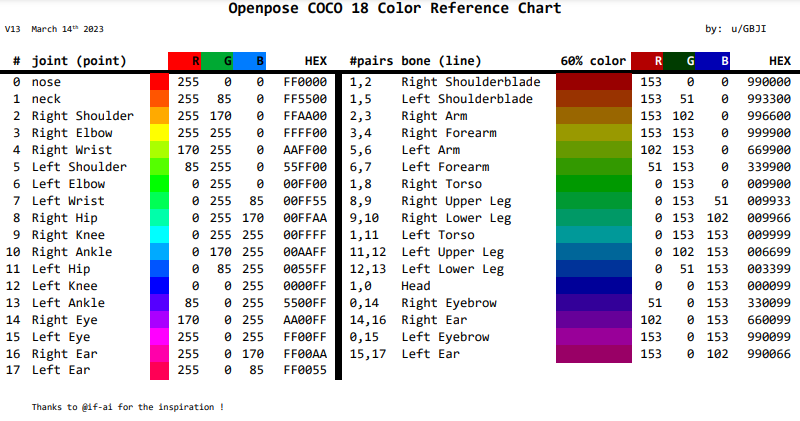

We should be able to use most of Openpose COCO color reference chart! [GH Discussion](https://github.com/lllyasviel/ControlNet/discussions/266)


In [89]:
ap10k_kpt_colors = {
    "left_eye": (255, 0, 255),
    "right_eye": (170, 0, 255),
    "nose": (255, 0, 0),
    "neck": (255, 85, 0),
    "root_of_tail": (41, 163, 129),  # Custom!
    "left_shoulder": (85, 255, 0),
    "left_elbow": (0, 255, 0),
    "left_front_paw": (0, 255, 85),  # In place of left wrist
    "right_shoulder": (255, 170, 0),
    "right_elbow": (255, 255, 0),
    "right_front_paw": (170, 255, 85),  # In place of right wrist
    "left_hip": (0, 85, 255),
    "left_knee": (0, 0, 255),
    "left_back_paw": (85, 0, 255),  # In place of left ankle
    "right_hip": (0, 85, 255),
    "right_knee": (0, 255, 255),
    "right_back_paw": (0, 170, 255),  # In place of right ankle
}

ap10k_link_colors = {
    (1, 2): (153, 0, 153),
    (1, 3): (153, 0, 102),
    (2, 3): (102, 0, 153),
    (3, 4): (0, 0, 153),  # Neck
    (4, 5): (100, 100, 100),  # Back
    (4, 6): (153, 51, 0),  # Left shoulderblade
    (6, 7): (102, 153, 0),  # Left arm
    (7, 8): (51, 153, 0),  # Left forearm
    (4, 9): (153, 0, 0),  # Right shoulderblade
    (9, 10): (153, 102, 0),  # Right arm
    (10, 11): (153, 153, 0),  # Right forearm
    (5, 12): (0, 153, 153),  # Left upper leg
    (12, 13): (0, 102, 153),  # Left lower leg
    (13, 14): (0, 51, 153),  # Left ankle/foot
    (5, 15): (0, 153, 0),  # right upper leg
    (15, 16): (0, 153, 51),  # right lower leg
    (16, 17): (0, 153, 102),  # right ankle/foot
}


In [90]:
import numpy as np

# NOTE: the visualizer we use wants the colors in BGR format
kpt_colors = [tuple(list(ap10k_kpt_colors[name])) for name in keypoint_names]
link_colors = [tuple(list(ap10k_link_colors[tuple(link)])) for link in skeleton_links]

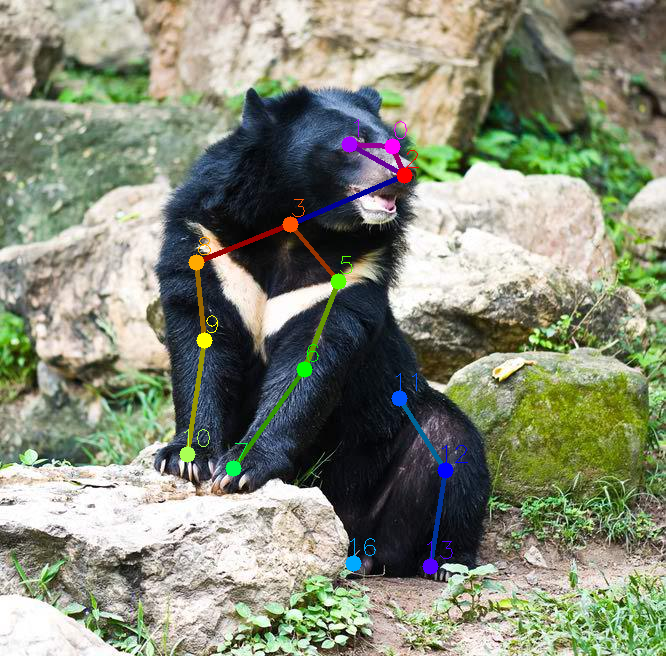

In [91]:
from mmengine.structures import InstanceData
from mmpose.structures import PoseDataSample
from mmpose.visualization import PoseLocalVisualizer

keypoints = []
all_keypoints = []
keypoint_visible = []
for i in range(len(annotations["keypoints"]) // 3):
    si = i * 3
    x, y, is_valid = annotations["keypoints"][si : si + 3]
    if is_valid > 0:
        keypoints.append((x, y))
    all_keypoints.append((x, y))
    keypoint_visible.append(is_valid > 0)
keypoints


# Have to subtract all values by 1, since the skeleton is 1 indexed
skeleton = [
    [link[0] - 1, link[1] - 1] for link in ann_data["categories"][1]["skeleton"]
]

pose_local_visualizer = PoseLocalVisualizer(
    radius=8,
    line_width=3,
    show_keypoint_weight=True,
    kpt_color=kpt_colors,
    link_color=link_colors,
)
gt_instances = InstanceData()
gt_instances.keypoints = np.array([all_keypoints])
gt_instances.keypoints_visible = np.array([keypoint_visible]).astype(np.uint8)
gt_pose_data_sample = PoseDataSample()
gt_pose_data_sample.gt_instances = gt_instances
dataset_meta = {"skeleton_links": skeleton}
pose_local_visualizer.set_dataset_meta(dataset_meta)
pose_img = pose_local_visualizer.add_datasample(
    "image",
    np.array(sample_image),
    gt_pose_data_sample,
    draw_pred=False,
    show_kpt_idx=True,
)
Image.fromarray(pose_img)

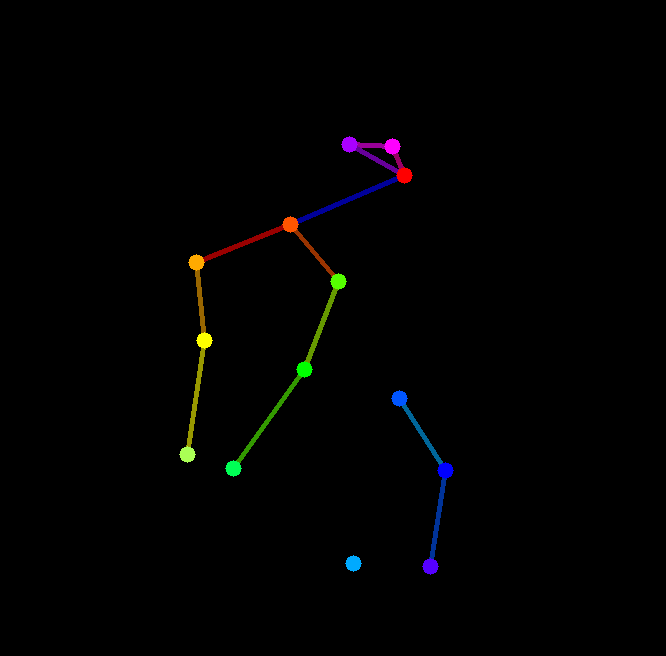

In [92]:
keypoints = []
all_keypoints = []
keypoint_visible = []
for i in range(len(annotations["keypoints"]) // 3):
    si = i * 3
    x, y, is_valid = annotations["keypoints"][si : si + 3]
    if is_valid > 0:
        keypoints.append((x, y))
    all_keypoints.append((x, y))
    keypoint_visible.append(is_valid > 0)
keypoints


# Have to subtract all values by 1, since the skeleton is 1 indexed
skeleton = [
    [link[0] - 1, link[1] - 1] for link in ann_data["categories"][1]["skeleton"]
]

pose_local_visualizer = PoseLocalVisualizer(
    radius=8,
    line_width=3,
    show_keypoint_weight=True,
    kpt_color=kpt_colors,
    link_color=link_colors,
)
gt_instances = InstanceData()
gt_instances.keypoints = np.array([all_keypoints])
gt_instances.keypoints_visible = np.array([keypoint_visible]).astype(np.uint8)
gt_pose_data_sample = PoseDataSample()
gt_pose_data_sample.gt_instances = gt_instances
dataset_meta = {"skeleton_links": skeleton}
pose_local_visualizer.set_dataset_meta(dataset_meta)
pose_img = pose_local_visualizer.add_datasample(
    "image",
    np.zeros_like(np.array(sample_image)),
    gt_pose_data_sample,
    draw_pred=False,
    show_kpt_idx=False,
)
img = Image.fromarray(pose_img)
img.save("test_pose.png")
img